In [1]:
# env: sex_diff
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import permutation_test

import os

## Draw sex prediction accuracy plot 
### Data: HCPA, HCPD; YA from 3 disease cohort (same acquisition as original A, D)
#### (1) load single flavor results (logistic regression)
#### (2) get ensemble results of original connectomes
#### (3) load ensemble covbat, Krakencoder results
#### (4) draw sex prediction accuracy across models

In [ ]:
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101] 
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']

flavor = 'SCifod2act_fs86_volnorm_dynseed'
data = scipy.io.loadmat(f'/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/{flavor}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]stratifiedCV_split0328_test30newYA_train_downsampledtrain30.mat')
n_connectivity = data['8-11'][0][0][0].shape[1]

In [ ]:
def load_data(flavor, outer_folds=100, bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]):
    data = scipy.io.loadmat(f'/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/{flavor}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]stratifiedCV_split0328_test30newYA_train_downsampledtrain30.mat')
    return data

sc_shen268_ifod2act = load_data('SCifod2act_shen268_volnormicv')
sc_fs86_ifod2act = load_data('SCifod2act_fs86_volnormicv')
sc_cocommpsuit439_ifod2act = load_data('SCifod2act_coco439_volnormicv')

sc_shen268_sdstream = load_data('SCsdstream_shen268_volnormicv')
sc_fs86_sdstream = load_data('SCsdstream_fs86_volnormicv')
sc_cocommpsuit439_sdstream = load_data('SCsdstream_coco439_volnormicv')

fc_shen268_FCcov_hpfgsr = load_data('FCcorr_shen268_hpfgsr')
fc_fs86_FCcov_hpfgsr = load_data('FCcorr_fs86_hpfgsr')
fc_cocommpsuit439_FCcov_hpfgsr = load_data('FCcorr_coco439_hpfgsr')

fc_shen268_FCcov_hpf = load_data('FCcorr_shen268_hpf')
fc_fs86_FCcov_hpf = load_data('FCcorr_fs86_hpf')
fc_cocommpsuit439_FCcov_hpf = load_data('FCcorr_coco439_hpf')

fc_shen268_FCpcorr_hpf = load_data('FCpcorr_shen268_hpf')
fc_fs86_FCpcorr_hpf = load_data('FCpcorr_fs86_hpf')
fc_cocommpsuit439_FCpcorr_hpf = load_data('FCpcorr_coco439_hpf')

In [7]:
flavors = [fc_fs86_FCcov_hpf, fc_fs86_FCcov_hpfgsr, fc_fs86_FCpcorr_hpf, sc_fs86_ifod2act, sc_fs86_sdstream, 
           fc_shen268_FCcov_hpf, fc_shen268_FCcov_hpfgsr, fc_shen268_FCpcorr_hpf, sc_shen268_ifod2act, sc_shen268_sdstream,
           fc_cocommpsuit439_FCcov_hpf, fc_cocommpsuit439_FCcov_hpfgsr, fc_cocommpsuit439_FCpcorr_hpf, sc_cocommpsuit439_ifod2act, sc_cocommpsuit439_sdstream]
flavorsFC = [fc_fs86_FCcov_hpf, fc_fs86_FCcov_hpfgsr, fc_fs86_FCpcorr_hpf, 
           fc_shen268_FCcov_hpf, fc_shen268_FCcov_hpfgsr, fc_shen268_FCpcorr_hpf,
           fc_cocommpsuit439_FCcov_hpf, fc_cocommpsuit439_FCcov_hpfgsr, fc_cocommpsuit439_FCpcorr_hpf]
flavorsSC = [sc_fs86_ifod2act, sc_fs86_sdstream, sc_shen268_ifod2act, sc_shen268_sdstream, sc_cocommpsuit439_ifod2act, sc_cocommpsuit439_sdstream]

flavors_name = ['fc_fs86_FCcov_hpf', 'fc_fs86_FCcov_hpfgsr', 'fc_fs86_FCpcorr_hpf', 'sc_fs86_ifod2act', 'sc_fs86_sdstream', 
           'fc_shen268_FCcov_hpf', 'fc_shen268_FCcov_hpfgsr', 'fc_shen268_FCpcorr_hpf', 'sc_shen268_ifod2act', 'sc_shen268_sdstream',
           'fc_cocommpsuit439_FCcov_hpf', 'fc_cocommpsuit439_FCcov_hpfgsr', 'fc_cocommpsuit439_FCpcorr_hpf', 'sc_cocommpsuit439_ifod2act', 'sc_cocommpsuit439_sdstream']

In [9]:
ensemble_mean = []
ensembleSC_mean = []
ensembleFC_mean = []

ensemble_reps = []
ensembleSC_reps = []
ensembleFC_reps = []

n_sc_models = 1 + len(flavorsSC)
half = n_sc_models // 2

for age in group_labels1:
    sc_shen268_test = sc_shen268_sdstream[age][0][0][4]
    true = sc_shen268_test[:,0,:]
    pred_total = sc_shen268_test[:,1,:] 
    predSC = sc_shen268_test[:,1,:]
    predFC = fc_shen268_FCcov_hpf[age][0][0][4][:,1,:]

    for i in range(len(flavors)):
        test_results = flavors[i][age][0][0][4]
        pred = test_results[:,1,:]
        pred_total = pred_total + pred
    pred_total[pred_total <= 7] = 0
    pred_total[pred_total >=8] = 1  

    for i in range(len(flavorsFC)):
        test_results = flavorsFC[i][age][0][0][4]
        pred = test_results[:,1,:]
        predFC = predFC + pred
    predFC[predFC <= 4] = 0
    predFC[predFC >=5] = 1  

    for i in range(len(flavorsSC)):
        test_results = flavorsSC[i][age][0][0][4]
        pred = test_results[:,1,:]
        predSC = predSC + pred

    predSC_labels = np.empty_like(predSC, dtype=int)
    predSC_labels[predSC >  half] = 1
    predSC_labels[predSC <  half] = 0
    tie_mask = (predSC == half)
    n_ties = tie_mask.sum()
    if n_ties > 0:
        np.random.seed(42)
        random_choices = np.random.randint(0, 2, size=n_ties)
        predSC_labels[tie_mask] = random_choices
    predSC = predSC_labels      

    FCSC_reps = np.mean(true == pred_total, axis=1)
    SC_reps = np.mean(true == predSC, axis=1)
    FC_reps = np.mean(true == predFC, axis=1)

    ensemble_reps.append(FCSC_reps)
    ensembleSC_reps.append(SC_reps)
    ensembleFC_reps.append(FC_reps)

    ensemble_mean.append(np.mean(FCSC_reps))
    ensembleSC_mean.append(np.mean(SC_reps))
    ensembleFC_mean.append(np.mean(FC_reps))

In [ ]:
def kraken_compare(data_use, ylim_min, bins, group_labels, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fig_size):
    outer_folds = 100
    n_bins      = len(bins) - 1
    fusion_types = [
        ('FCs Only (Fusion FC)',  'fusionFC'),
        ('SCs (Fusion SC)', 'fusionSC'),
        ('FCs + SCs (Fusion)', 'fusion')
    ]

    base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95'
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.flatten()

    palette={#'Sex Age - Site Fine-tuned Krakencoder': 'red',
              'Sex - Site Fine-tuned Krakencoder': 'pink', 
             'Sex Fine-tuned Krakencoder': '#C875C4',
            #'Fine-tuned Krakencoder': '#70B38E',
            'Krakencoder': 'coral',
            'Ensemble': 'steelblue',
            'Ensemble Covbat': 'lightblue'} 

    handles = []
    labels = []

    with open('/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/covbat/covbat_ensemble_reps0912.pkl', 'rb') as f:
        ensemblecb_data = pickle.load(f)
        ensemblecb_reps = ensemblecb_data['ensemble_reps']
        ensemblecbFC_reps = ensemblecb_data['ensembleFC_reps']
        ensemblecbSC_reps = ensemblecb_data['ensembleSC_reps']

    for ax, (title, fusion_key) in zip(axes[:3], fusion_types):
        dfs = []

        # build the ensemble_covbat DataFrame…

        if fusion_key == 'fusion':
            repcb_list = ensemblecb_reps; enscb_label = 'Ensemble Covbat'
        elif fusion_key == 'fusionFC':
            repcb_list = ensemblecbFC_reps; enscb_label = 'Ensemble Covbat'
        else:
            repcb_list = ensemblecbSC_reps; enscb_label = 'Ensemble Covbat'

        repcb_list = [np.asarray(r) for r in repcb_list]
        enscb_arr  = np.array(repcb_list).T   # shape = (100, n_bins)
        enscb_df   = pd.DataFrame(enscb_arr, columns=group_labels)
        enscb_df['model'] = enscb_label
        dfs.append(enscb_df)

        # build the ensemble DataFrame…
        if fusion_key == 'fusion':
            rep_list = ensemble_reps; ens_label = 'Ensemble'
        elif fusion_key == 'fusionFC':
            rep_list = ensembleFC_reps; ens_label = 'Ensemble'
        else:
            rep_list = ensembleSC_reps; ens_label = 'Ensemble'

        rep_list = [np.asarray(r) for r in rep_list]
        ens_arr  = np.array(rep_list).T   # shape = (100, n_bins)
        ens_df   = pd.DataFrame(ens_arr, columns=group_labels)
        ens_df['model'] = ens_label
        dfs.append(ens_df)

        # load Krakencoder variants…
        for label, subdir in [
            ('Krakencoder',            'krakencoder_original'),
            ('Sex Fine-tuned Krakencoder','krakencoder500_sex0508'),
            ('Sex - Site Fine-tuned Krakencoder', 'krakencoder500_sex0508_site_rm')#,
        ]:
            path = os.path.join(
                base_dir,
                subdir,
                f'results1110/encoded_pred{fusion_key}{bins}{data_use}_logistic.mat'
            )
            mat = scipy.io.loadmat(path, simplify_cells=True)
            arr = np.zeros((outer_folds, n_bins))
            for i in range(n_bins):
                key = f"{bins[i]}-{bins[i+1]}"
                arr[:, i] = mat[key]['test_accuracy'].ravel()
            df = pd.DataFrame(arr, columns=group_labels)
            df['model'] = label
            dfs.append(df)


        df_long = pd.concat(dfs, ignore_index=True).melt(
            id_vars='model', var_name='age_group', value_name='accuracy'
        )
        df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=group_labels, ordered=True)
        sns.boxplot(
            x='age_group', y='accuracy',
            hue='model', data=df_long,
            dodge=True, ax=ax, palette = palette
        )

        x = np.arange(0, len(group_labels))
        med_df = (df_long.groupby(['model','age_group'], observed=False)['accuracy'].median().reset_index())
        x_smooth = np.linspace(0, len(group_labels)-1, 500)
        offset_map = {
            'Ensemble Covbat': -0.5,
            'Ensemble': -0.25,
            'Krakencoder': -0.1,
            'Sex Fine-tuned Krakencoder': +0.1,
            'Sex - Site Fine-tuned Krakencoder': +0.3
        }
        for model_label, color in palette.items():
            dx = offset_map[model_label]
            m = med_df[med_df['model']==model_label]
            medians = m.set_index('age_group').reindex(group_labels)['accuracy'].values
            spl = make_interp_spline(x, medians, k=3)

        ax.set_title(title)
        ax.set_xlabel("Age Range")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(ylim_min, 1.05)
        ax.set_yticks(np.arange(ylim_min, 1.05 + 1e-8, 0.1))
        ax.tick_params(axis='x', rotation=45)
        if not handles:
            handles, labels = ax.get_legend_handles_labels()

        ax.get_legend().remove()
        axes[3].axis('off')

    fig.legend(handles, labels, title="Model", loc='center right', bbox_to_anchor=(0.78, 0.3))
    fig.text(0.02, 0.97, "a)", fontsize=17, ha='right')   
    plt.tight_layout()
    plt.show()

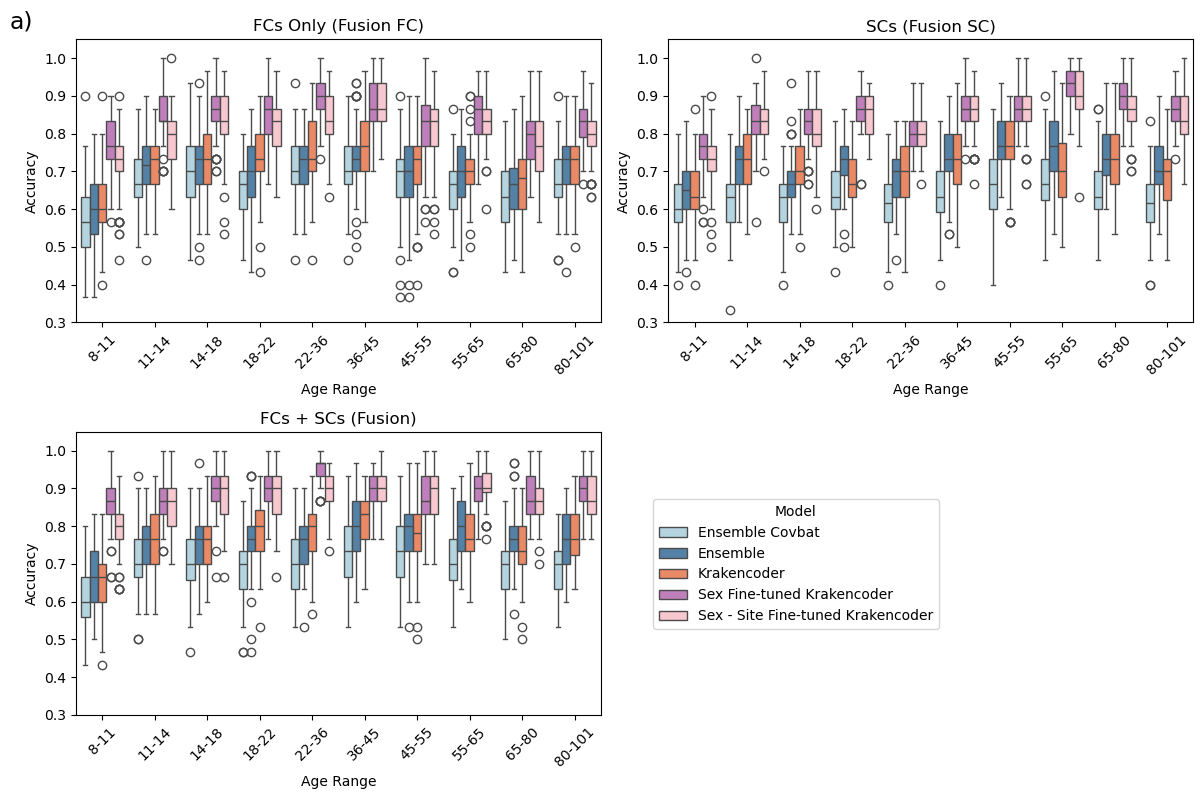

In [19]:
# seed 42
bin = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
kraken_compare('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', 0.3, bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, (12, 8))

In [ ]:
def kraken_compare(data_use, ylim_min, bins, group_labels, ensemble_reps, ensembleFC_reps, ensembleSC_reps, fig_size):
    outer_folds = 100
    n_bins      = len(bins) - 1
    fusion_types = [
        ('FCs Only (Fusion FC)',  'fusionFC'),
        ('SCs (Fusion SC)', 'fusionSC'),
        ('FCs + SCs (Fusion)', 'fusion')
    ]

    base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95'
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.flatten()

    palette={'Sex Fine-tuned Krakencoder': 'palevioletred', 
            'Krakencoder': 'coral', 'Ensemble': 'steelblue'} 

    handles = []
    labels = []

    for ax, (title, fusion_key) in zip(axes[:3], fusion_types):
        dfs = []

        # build the ensemble DataFrame…
        if fusion_key == 'fusion':
            rep_list = ensemble_reps; ens_label = 'Ensemble'
        elif fusion_key == 'fusionFC':
            rep_list = ensembleFC_reps; ens_label = 'Ensemble'
        else:
            rep_list = ensembleSC_reps; ens_label = 'Ensemble'

        rep_list = [np.asarray(r) for r in rep_list]
        ens_arr  = np.array(rep_list).T   # shape = (100, n_bins)
        ens_df   = pd.DataFrame(ens_arr, columns=group_labels)
        ens_df['model'] = ens_label
        dfs.append(ens_df)

        # load your three Krakencoder variants…
        for label, subdir in [
            ('Krakencoder',            'krakencoder_original'),
            ('Sex Fine-tuned Krakencoder','krakencoder500_sex0508'),
        ]:
            path = os.path.join(
                base_dir,
                subdir,
                f'results1110/encoded_pred{fusion_key}{bins}{data_use}_logistic.mat'

            )
            mat = scipy.io.loadmat(path, simplify_cells=True)
            arr = np.zeros((outer_folds, n_bins))
            for i in range(n_bins):
                key = f"{bins[i]}-{bins[i+1]}"
                arr[:, i] = mat[key]['test_accuracy'].ravel()
            df = pd.DataFrame(arr, columns=group_labels)
            df['model'] = label
            dfs.append(df)


        df_long = pd.concat(dfs, ignore_index=True).melt(
            id_vars='model', var_name='age_group', value_name='accuracy'
        )
        df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=group_labels, ordered=True)
        sns.boxplot(
            x='age_group', y='accuracy',
            hue='model', data=df_long,
            dodge=True, ax=ax, palette = palette
        )

        x = np.arange(0, len(group_labels))
        med_df = (df_long.groupby(['model','age_group'], observed=False)['accuracy'].median().reset_index())
        x_smooth = np.linspace(0, len(group_labels)-1, 500)
        offset_map = {
            'Ensemble': -0.1,
            'Krakencoder': 0.0,
            'Sex Fine-tuned Krakencoder': +0.1,
        }
        for model_label, color in palette.items():
            dx = offset_map[model_label]
            m = med_df[med_df['model']==model_label]
            medians = m.set_index('age_group').reindex(group_labels)['accuracy'].values
            spl = make_interp_spline(x, medians, k=3)
            ax.plot(x_smooth+dx, spl(x_smooth), linewidth=0.9, color=color, label=None)    # add splines

        ax.set_title(title, fontsize=10)
        ax.set_xlabel("Age Range", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.set_ylim(ylim_min, 1.05)
        ax.set_yticks(np.arange(ylim_min, 1.05 + 1e-8, 0.1))
        ax.tick_params(axis='x', rotation=45)
        for j_pos in range(10):
            ax.text(0.4 + j_pos, 0.3, "*", color='palevioletred', fontsize=12, fontweight='bold', ha='right')
            ax.text(0.4 + j_pos, 0.33, "*", color='palevioletred', fontsize=12, fontweight='bold', ha='right')
        if not handles:
            handles, labels = ax.get_legend_handles_labels()

        ax.get_legend().remove()
        axes[3].axis('off')
        for j_pos in range(3,7):
            axes[0].text(0.15 + j_pos, 0.3, "*", color='coral', fontsize=12, fontweight='bold', ha='right')
            axes[0].text(0.15 + j_pos, 0.33, "*", color='coral', fontsize=12, fontweight='bold', ha='right')  
        for j_pos in range(3,5):
            axes[2].text(0.15 + j_pos, 0.3, "*", color='coral', fontsize=12, fontweight='bold', ha='right')
            axes[2].text(0.15 + j_pos, 0.33, "*", color='coral', fontsize=12, fontweight='bold', ha='right')              
        axes[1].text(0.15 + 2, 0.3, "*", color='coral', fontsize=12, fontweight='bold', ha='right')          
        axes[1].text(0.15 + 2, 0.33, "*", color='coral', fontsize=12, fontweight='bold', ha='right')  

    fig.legend(handles, labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=len(labels), frameon=False)
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    fig.text(0.02, 0.98, "a)", fontsize=11, ha='right') 
    fig.text(0.52, 0.98, "b)", fontsize=11, ha='right') 
    fig.text(0.02, 0.5, "c)", fontsize=11, ha='right') 
    plt.show()

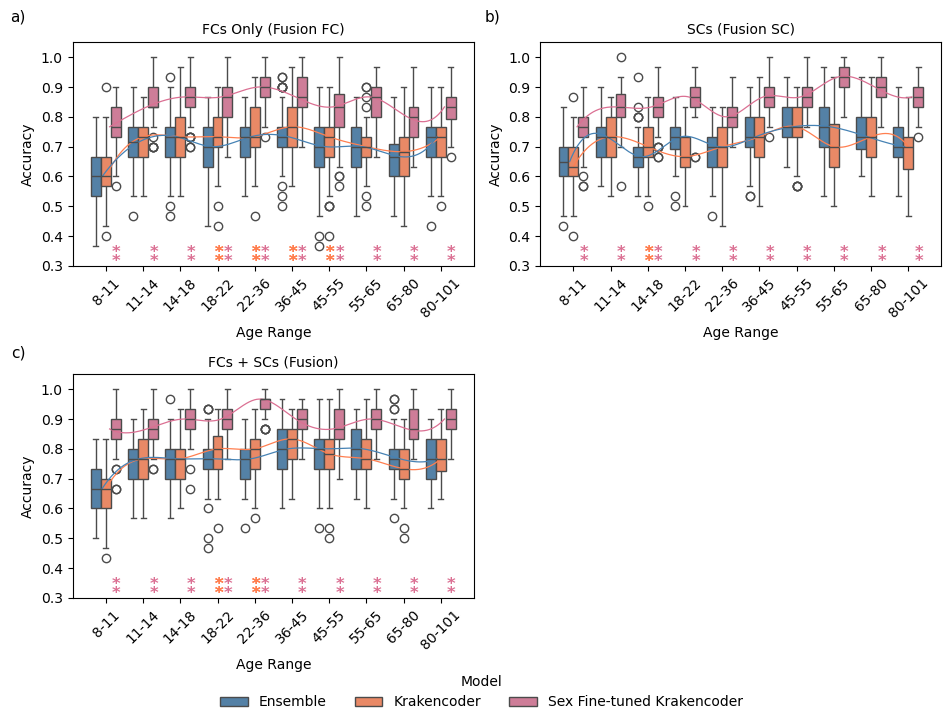

In [21]:
# seed 42
bin = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
kraken_compare('_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30', 0.3, bin, group_labels1, ensemble_reps, ensembleFC_reps, ensembleSC_reps, (9.5, 7))

In [ ]:
from statsmodels.stats.multitest import multipletests
base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95'
fusion_key = 'fusionSC' # 'fusionFC', 'fusionSC', 'fusion'
ensemble_results = ensembleSC_reps.copy()
data_use = '_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30'

outer_folds = 100; n_bins = 10
kraken_sex_acc = {}
subdir = 'krakencoder_original'#'krakencoder500_sex0508' #'krakencoder500_sex0508' # 'krakencoder_original' # 'krakencoder500_0328'
path = os.path.join(base_dir, subdir, f'results1110/encoded_pred{fusion_key}{bins}{data_use}_logistic.mat')
mat = scipy.io.loadmat(path, simplify_cells=True)

labels, stats_raw, p_raw = [], [], []
for i in range(n_bins):
    key = f"{bins[i]}-{bins[i+1]}"
    kraken_acc = np.asarray(mat[key]['test_accuracy']).ravel()
    ensemble_acc = np.asarray(ensemble_results[i]).ravel()

    # one-sided permutation test: kraken > ensemble
    res = permutation_test((kraken_acc, ensemble_acc),  statistic=lambda a, b: a.mean() - b.mean(),
        n_resamples=10000,  alternative='greater', permutation_type='samples')

    labels.append(key)
    stats_raw.append(res.statistic)
    p_raw.append(res.pvalue)

stats_raw = np.array(stats_raw)
p_raw = np.array(p_raw)

# FDR Benjamini–Hochberg
q_bh = multipletests(p_raw, method="fdr_bh")[1]
# Holm–Bonferroni
p_holm = multipletests(p_raw, method="holm")[1]

# print summary
print("Bin\t meanΔ(kraken-ens)\t p_raw\t\tq_BH(FDR)\t p_Holm(FWER)")
for lbl, s, p, q, ph in zip(labels, stats_raw, p_raw, q_bh, p_holm):
    print(f"{lbl}\t{s:.4f}\t\t{p:.4g}\t\t{q:.4g}\t\t{ph:.4g}")

Bin	 meanΔ(kraken-ens)	 p_raw		q_BH(FDR)	 p_Holm(FWER)
8-11	-0.0077		0.7828		1		1
11-14	0.0007		0.4808		1		1
14-18	0.0297		0.0003		0.003		0.003
18-22	-0.0420		1		1		1
22-36	0.0083		0.1722		0.8609		1
36-45	0.0003		0.4904		1		1
45-55	-0.0093		0.8748		1		1
55-65	-0.0397		0.9999		1		1
65-80	-0.0200		0.9982		1		1
80-101	-0.0340		0.9999		1		1
